<a href="https://colab.research.google.com/github/andrebeu/csw_repo/blob/master/SEM_notebook1_070120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation:
In colab, SEM will be installed by the code below.  To run this on a local machine, this code requires python 3.6+ and assumes the anaconda python distribution.  There are a bunch of dependencies (noteably, tensorflow) to run SEM.  These will be installed with SEM.  I'm not sure the plotting functions (e.g. seaborn) will installed with SEM.

In [5]:
## comment out if running locally and SEM is already installed
!pip install git+https://github.com/nicktfranklin/SEM2

  Cloning https://github.com/nicktfranklin/SEM2 to /tmp/pip-req-build-flc071sh
  Running command git clone -q https://github.com/nicktfranklin/SEM2 /tmp/pip-req-build-flc071sh
  Created wheel for sem: filename=sem-2.0-cp36-none-any.whl size=21343 sha256=168b8d256e37713b102fb79ecb30950ea32f22cf8da45c8bcf8a15073f60a7d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hiqeuheq/wheels/fd/04/8e/297154c59fa12da8fadae9a21fc340991e75e39748d36b2a02
Successfully built sem


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
import pandas as pd

from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from scipy.special import logsumexp
from scipy.stats import norm
from glob import glob


"""## Define experiment"""
import sys, os
# add the current path to python to allow loading SEM
current_path = os.path.abspath('.')
parent_path = os.path.dirname(current_path)
sys.path.append(parent_path)

from sem import sem_run_with_boundaries

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow Version: 2.2.0


# Custom Version of SEM
This is a version of SEM that doesn't segment (no split) I have it hear so I 
don't have to update the github repository for SEM everytime I need a new feature

In [7]:
import numpy as np
import tensorflow as tf
from scipy.special import logsumexp
from tqdm import tqdm
from sem.event_models import GRUEvent
from sem.utils import delete_object_attributes, processify

# there are a ~ton~ of tf warnings from Keras, suppress them here
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


class Results(object):
    """ placeholder object to store results """
    pass


class NoSplitSEM(object):
    """ This is a custom variant of SEM that doesn't allow for segementation"""

    def __init__(self, lmda=1., alfa=10.0, f_class=GRUEvent, f_opts=None):
        """
        Parameters
        ----------

        lmda: float
            sCRP stickiness parameter

        alfa: float
            sCRP concentration parameter

        f_class: class
            object class that has the functions "predict" and "update".
            used as the event model

        f_opts: dictionary
            kwargs for initializing f_class
        """
        self.lmda = lmda
        self.alfa = alfa
        # self.beta = beta

        if f_class is None:
            raise ValueError("f_model must be specified!")

        self.f_class = f_class
        self.f_opts = f_opts

        # SEM internal state
        #
        self.k = 0  # maximum number of clusters (event types)
        self.c = np.array([])  # used by the sCRP prior -> running count of the clustering process
        self.d = None  # dimension of scenes
        self.event_models = dict()  # event model for each event type
        self.model = None # this is the tensorflow model that gets used

        self.x_prev = None  # last scene
        self.k_prev = None  # last event type

        self.x_history = np.zeros(())

        # instead of dumping the results, store them to the object
        self.results = None

    def _update_state(self, x, k=None):
        """
        Update internal state based on input data X and max # of event types (clusters) K
        """
        # get dimensions of data
        [n, d] = np.shape(x)
        if self.d is None:
            self.d = d
        else:
            assert self.d == d  # scenes must be of same dimension

        # get max # of clusters / event types
        if k is None:
            k = n
        self.k = max(self.k, k)

        # initialize CRP prior = running count of the clustering process
        if self.c.size < self.k:
            self.c = np.concatenate((self.c, np.zeros(self.k - self.c.size)), axis=0)
        assert self.c.size == self.k

    def _calculate_unnormed_sCRP(self, prev_cluster=None):
        # internal function for consistency across "run" methods

        # calculate sCRP prior
        prior = self.c.copy()
        idx = len(np.nonzero(self.c)[0])  # get number of visited clusters

        if idx <= self.k:
            prior[idx] += self.alfa  # set new cluster probability to alpha

        # add stickiness parameter for n>0, only for the previously chosen event
        if prev_cluster is not None:
            prior[prev_cluster] += self.lmda

        # prior /= np.sum(prior)
        return prior

    def update_single_event(self, x, update=True, save_x_hat=False):
        """

        :param x: this is an n x d array of the n scenes in an event
        :param update: boolean (default True) update the prior and posterior of the event model
        :param save_x_hat: boolean (default False) normally, we don't save this as the interpretation can be tricky
        N.b: unlike the posterior calculation, this is done at the level of individual scenes within the
        events (and not one per event)
        :return:
        """

        n_scene = np.shape(x)[0]

        if update:
            self.k = 1
            self._update_state(x, self.k)

            # pull the relevant items from the results
            if self.results is None:
                self.results = Results()
                post = np.zeros((1, self.k))
                log_like = np.zeros((1, self.k)) - np.inf
                log_prior = np.zeros((1, self.k)) - np.inf
                if save_x_hat:
                    x_hat = np.zeros((n_scene, self.d))
                    sigma = np.zeros((n_scene, self.d))
                    scene_log_like = np.zeros((n_scene, self.k)) - np.inf # for debugging

            else:
                post = self.results.post
                log_like = self.results.log_like
                log_prior = self.results.log_prior
                if save_x_hat:
                    x_hat = self.results.x_hat
                    sigma = self.results.sigma
                    scene_log_like = self.results.scene_log_like  # for debugging

                # extend the size of the posterior, etc

                n, k0 = np.shape(post)
                while k0 < self.k:
                    post = np.concatenate([post, np.zeros((n, 1))], axis=1)
                    log_like = np.concatenate([log_like, np.zeros((n, 1)) - np.inf], axis=1)
                    log_prior = np.concatenate([log_prior, np.zeros((n, 1)) - np.inf], axis=1)
                    n, k0 = np.shape(post)

                    if save_x_hat:
                        scene_log_like = np.concatenate([
                            scene_log_like, np.zeros((np.shape(scene_log_like)[0], 1)) - np.inf
                            ], axis=1)

                # extend the size of the posterior, etc
                post = np.concatenate([post, np.zeros((1, self.k))], axis=0)
                log_like = np.concatenate([log_like, np.zeros((1, self.k)) - np.inf], axis=0)
                log_prior = np.concatenate([log_prior, np.zeros((1, self.k)) - np.inf], axis=0)
                if save_x_hat:
                    x_hat = np.concatenate([x_hat, np.zeros((n_scene, self.d))], axis=0)
                    sigma = np.concatenate([sigma, np.zeros((n_scene, self.d))], axis=0)
                    scene_log_like = np.concatenate([scene_log_like, np.zeros((n_scene, self.k)) - np.inf], axis=0)

        else:
            log_like = np.zeros((1, self.k)) - np.inf
            log_prior = np.zeros((1, self.k)) - np.inf

        # calculate un-normed sCRP prior
        prior = [1]

        # likelihood
        active = np.nonzero(prior)[0]
        lik = np.zeros((n_scene, len(active)))

        # again, this is a readout of the model only and not used for updating,
        # but also keep track of the within event posterior
        if save_x_hat:
            _x_hat = np.zeros((n_scene, self.d))  # temporary storre
            _sigma = np.zeros((n_scene, self.d))


        for ii, x_curr in enumerate(x):

            # we need to maintain a distribution over possible event types for the current events --
            # this gets locked down after termination of the event.
            # Also: none of the event models can be updated until *after* the event has been observed

            # special case the first scene within the event
            if ii == 0:
                event_boundary = True
            else:
                event_boundary = False

            # loop through each potentially active event model and verify 
            # a model has been initialized
            for k0 in active:
                if k0 not in self.event_models.keys():
                    new_model = self.f_class(self.d, **self.f_opts)
                    if self.model is None:
                        self.model = new_model.init_model()
                    else:
                        new_model.set_model(self.model)
                    self.event_models[k0] = new_model

            ### ~~~~~ Start ~~~~~~~###

            ## prior to updating, pull x_hat based on the ongoing estimate of the event label
            k_within_event = 0
            
            if save_x_hat:
                if event_boundary:
                    _x_hat[ii, :] = self.event_models[k_within_event].predict_f0()
                else:
                    _x_hat[ii, :] = self.event_models[k_within_event].predict_next_generative(x[:ii, :])
                _sigma[ii, :] = self.event_models[k_within_event].get_variance()


            ## Update the model, inference first!
            for k0 in active:
                # get the log likelihood for each event model
                model = self.event_models[k0]

                if not event_boundary:
                    # this is correct.  log_likelihood sequence makes the model prediction internally
                    # using predict_next_generative, and evaluates the likelihood of the prediction
                    lik[ii, k0] = model.log_likelihood_sequence(x[:ii, :].reshape(-1, self.d), x_curr)
                else:
                    lik[ii, k0] = model.log_likelihood_f0(x_curr)
            


        # cache the diagnostic measures
        log_like[-1, 0] = np.sum(lik, axis=0)

        # calculate the log prior
        log_prior[-1, :len(active)] = np.log(prior[:len(active)])

        # calculate surprise
        bayesian_surprise = logsumexp(lik + np.tile(log_prior[-1, :len(active)], (np.shape(lik)[0], 1)), axis=1)

        if update:

            # at the end of the event, find the winning model!
            log_post = log_prior[-1, :len(active)] + log_like[-1, :len(active)]
            post[-1, :len(active)] = np.exp(log_post - logsumexp(log_post))
            k = 0

            # update the prior
            self.c[k] += n_scene
            # cache for next event
            self.k_prev = k

            # update the winning model's estimate
            self.event_models[k].update_f0(x[0])
            x_prev = x[0]
            for X0 in x[1:]:
                self.event_models[k].update(x_prev, X0)
                x_prev = X0

            self.results.post = post
            self.results.log_like = log_like
            self.results.log_prior = log_prior
            self.results.e_hat = np.argmax(post, axis=1)
            self.results.log_loss = logsumexp(log_like + log_prior, axis=1)

            if save_x_hat:
                x_hat[-n_scene:, :] = _x_hat
                sigma[-n_scene:, :] = _sigma
                scene_log_like[-n_scene:, :len(active)] = lik
                self.results.x_hat = x_hat
                self.results.sigma = sigma
                self.results.scene_log_like = scene_log_like

        return

    def init_for_boundaries(self, list_events):
        # update internal state

        k = 0
        self._update_state(np.concatenate(list_events, axis=0), k)
        del k  # use self.k and self.d

        # store a compiled version of the model and session for reuse
        if self.k_prev is None:

            # initialize the first event model
            new_model = self.f_class(self.d, **self.f_opts)
            self.model = new_model.init_model()

            self.event_models[0] = new_model

    def run_w_boundaries(self, list_events, progress_bar=True, leave_progress_bar=True, save_x_hat=False, 
                         generative_predicitons=False, minimize_memory=False):
        """
        This method is the same as the above except the event boundaries are pre-specified by the experimenter
        as a list of event tokens (the event/schema type is still inferred).

        One difference is that the event token-type association is bound at the last scene of an event type.
        N.B. ! also, all of the updating is done at the event-token level.  There is no updating within an event!

        evaluate the probability of each event over the whole token


        Parameters
        ----------
        list_events: list of n x d arrays -- each an event


        progress_bar: bool
            use a tqdm progress bar?

        leave_progress_bar: bool
            leave the progress bar after completing?

        save_x_hat: bool
            save the MAP scene predictions?

        Return
        ------
        post: n_e by k array of posterior probabilities

        """

        # loop through the other events in the list
        if progress_bar:
            def my_it(iterator):
                return tqdm(iterator, desc='Run SEM', leave=leave_progress_bar)
        else:
            def my_it(iterator):
                return iterator

        self.init_for_boundaries(list_events)

        for x in my_it(list_events):
            self.update_single_event(x, save_x_hat=save_x_hat)
        if minimize_memory:
            self.clear_event_models()

    def clear_event_models(self):
        if self.event_models is not None:
            for _, e in self.event_models.items():
                e.clear()
                e.model = None
            
        self.event_models = None
        self.model = None
        tf.compat.v1.reset_default_graph()  # for being sure
        tf.keras.backend.clear_session()

    def clear(self):
        """ This function deletes sem from memory"""
        self.clear_event_models()
        delete_object_attributes(self.results)
        delete_object_attributes(self)




@processify
def no_split_sem_run_with_boundaries(x, sem_init_kwargs=None, run_kwargs=None):
    """ this initailizes SEM, runs the main function 'run', and
    returns the results object within a seperate process.
    
    See help on SEM class and on subfunction 'run_w_boundaries' for more detail on the 
    parameters contained in 'sem_init_kwargs'  and 'run_kwargs', respectively.

    """
    
    if sem_init_kwargs is None:
        sem_init_kwargs=dict()
    if run_kwargs is None:
        run_kwargs=dict()
    
    sem_model = NoSplitSEM(**sem_init_kwargs)
    sem_model.run_w_boundaries(x, **run_kwargs)
    return sem_model.results

# Code for Task
Here, I've all of the code used to creat the task.  It's ugly....

In [8]:
"""Schema Prediction, Andre's version, 5/12/20


This notebook includes all of the code for the experients and analyses.  It uses a python v3 and 
tensorflow v1.14 port of the SEM model.  This version is mimics the tasks that Andre ran but 
is simper in its representation.

## Load Libraries
"""

import numpy as np
import json
from tqdm import tqdm

# used in the experimental design
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing # used sparingly
from scipy.special import logsumexp

# ########## code to load SEM ##########
# ##### imports from SEM model
# import sys, os
# # add the current path to python to allow loading SEM
# current_path = os.path.abspath('.')
# parent_path = os.path.dirname(current_path)
# sys.path.append(parent_path)

from sem import sem_run_with_boundaries, SEM
from sem.hrr import plate_formula, encode, decode, embed_gaussian
from sem.utils import fast_mvnorm_diagonal_logprob, get_prior_scale, processify
# from no_split_sem import no_split_sem_run_with_boundaries, NoSplitSEM



"""## Define Experiment"""


## these are utility functions

def get_boundaries(e_hat):
    return np.array(
        np.concatenate([np.array([0]), e_hat[0:-1] != e_hat[1:]]), dtype=bool
    )

def logsumexp_mean(x):
    """ return the log of the mean, given a 1-d array of log values"""
    return logsumexp(x) - np.log(len(x))

def generate_exp(condition, seed=None, err=0.1, n_train=160, n_test=40, embedding_library=None, 
                    actor_weight=1.0):
    """
    :param condition: (str), either 'blocked', 'interleaved', 'early', 'middle', or 'late'
    :param seed: (int), random seed for consistency
    :param err: (float, default=0.1) error probability in Plate's forumla
    :param n_train: (int, default=160), number of train events
    :param n_test: (int, default=40), number of test events
    :param embedding_library: (dictionary, default=None) contains the word embeddings,
        to allow a single library to be reused mutliple times
    :param actor_weight: (float, default=1) how much to weight the actor in the representation


    Each scene in the experiment is the conjunction of 2 terms: 
    (1) agent + (2) node

    Andre's task has the following two graph structures:

    "Brew house"
    -------------
                        ->  Node11 -> Node21 -> Node31
    Begin -> LocNodeB                                   -> End
                        ->  Node12 -> Node22 -> Node32


    "Deep Ocean Cafe"
    -------------
                        ->  Node11 -> Node22 -> Node31
    Begin -> LocNodeC                                   -> End
                        ->  Node12 -> Node21 -> Node32

    These graphs are diffrentiaed by "LocNodeB" and "LocNodeC" and the 
    transitions after Nodes11/12 and Nodes21/22.  The graphs are otherwise identicial,
    will all tranistions determinstic, except those following LocNodeB and LocNodeC.

    The nodes in the task graps are listed as integers with the 
    following correspondance:
        LocNodeB:   0
        LocNodeC:   1
        Node11:     2
        Node12:     3
        Node21:     4
        Node22:     5
        Node31:     6
        Node32:     7

    Note that each feature is unique to each scene and there is no shared 
    correlation structure for these features.


    """

    # check for valid condition type
    assert type(condition) == str        
    if condition[0].lower() == 'b':
        condition = 'blocked'
    elif (condition[0].lower() == 'i'):
        condition = 'interleaved'
    elif (condition[0].lower() == 'e'):
        condition = 'early'
    elif (condition[0].lower() == 'm'):
        condition = 'middle'
    elif (condition[0].lower() == 'l'):
        condition = 'late'
    else:
        message = 'Condition Specified: {}\nPlease specify either blocked or interleaved!'.format(condition)
        raise(Exception(message))


    if seed is not None:
        assert type(seed) == int
        np.random.seed(seed)

    # transition functions are defined T(s, s') = p
    # these are the "Brew house" stories
    transition_probs_b = {
        (0, 2): 0.5, (0, 3): 0.5, 
        (2, 4): 1.0,
        (3, 5): 1.0, 
        (4, 6): 1.0,
        (5, 7): 1.0,
    }

    # these are the "Deep Ocean Cafe" stories
    transition_probs_c = {
        (1, 2): 0.5, (1, 3): 0.5, 
        (2, 5): 1.0,
        (3, 4): 1.0, 
        (4, 7): 1.0,
        (5, 6): 1.0,
    }
    
    def make_t_matrix(transition_prob_dict):
        t = np.zeros((8, 8))
        for (x, y), p in transition_prob_dict.items():
            t[x, y] = p
        return t

    # python logic makes it easier to rename these types as b=0, c=1
    transitions = {
        0: make_t_matrix(transition_probs_b),
        1: make_t_matrix(transition_probs_c)
    }

    # generate the order of the events
    list_transitions = []   # this is a list of the 
                            # transitions to use in each trial, as a function of trial number
    if condition == 'blocked':
        list_transitions =  \
            [0] * (n_train // 4) + \
            [1] * (n_train // 4) + \
            [0] * (n_train // 4) + \
            [1] * (n_train // 4 )
    elif condition == 'early':
        list_transitions =  \
            [0] * (n_train // 4) + \
            [1] * (n_train // 4) + \
            [0, 1] * (n_train // 4)
    elif condition == 'middle':
        list_transitions =  \
            [0, 1] * (n_train // 8) + \
            [0] * (n_train // 4) + \
            [1] * (n_train // 4) + \
            [0, 1] * (n_train // 8)
    elif condition == 'late':
        list_transitions =  \
            [0, 1] * (n_train // 4) + \
            [0] * (n_train // 4) + \
            [1] * (n_train // 4)
    else:
        list_transitions = [0, 1] * (n_train // 2)

    # randomly flip which one starts off
    _X = int(np.random.rand() < 0.5)
    list_transitions = [abs(l-_X) for l in list_transitions]

    # add the test trials. These are always random
    list_transitions += [int(np.random.rand() < 0.5) for _ in range(n_test)]

    # draw the training/test stories
    stories = []
    y = []
    e = []
    for ii in range(n_train + n_test):
        a = 'Actor{}'.format(ii)
        # draw the nodes
        t = transitions[list_transitions[ii]]
        e.append(list_transitions[ii])

        # encode the initial scene
        if e[-1] == 0:
            n = 0  # pick the initial scene
        else:
            n = 1

        x0 = [['Verb0', a]]
        y.append(n)
        while n < 6:  # draw all of the scenes until the last scene (scene 6 or 7) is reached
            # draw a random scene, conditioned on the current scene, using the transition function
            n = np.arange(0, 8)[np.sum(np.cumsum(t[n, :]) < np.random.uniform(0, 1))]

            # encode the scenes
            v = 'Verb{}'.format(n)
            x0.append([v, a])
            y.append(n)
        stories.append(x0)


    # # figure out how many dimensions we need using plates formula
    n_verbs = 10  # verbs
    # n = n_train * 2 + n_test + n_verbs
    # k = 2  # maximum number of terms to be combined

    # d = plate_formula(n, k, err)

    # as a simplifying assumption, we will not use the full embedding or calculate it's
    # dimensions with Plate's formula.  Instead, we will set the number of dimensions to the 
    # the number of nodes in the graph
    d = n_verbs
    
    if embedding_library is None:
        verb_property = embed_gaussian(d)
        agent_property = embed_gaussian(d)

        # when combining terms, devide by sqrt(n_terms) to keep expected length ~1.0
        embedding_library = {
            'Verb{}'.format(ii): (embed_gaussian(d) + verb_property) / np.sqrt(2.0) 
            for ii in range(n_verbs)
        }
        embedding_library.update({
            'Actor{}'.format(ii): (embed_gaussian(d) + agent_property)  / np.sqrt(2.0) 
            for ii in range(n_train + n_test)
        })

    keys = list(embedding_library.keys())
    keys.sort()

    # ~~~~~ 
    #### encode the stories  as vectors       
    def encode_scene(s):
        X = embedding_library[s[0]] + embedding_library[s[1]] * actor_weight
        # divide by sqrt(2), as specified in plate, 1995, to keep expected 
        # length at ~1.0
        return X / np.sqrt(1 + actor_weight)

    x = []  
    for s in stories:
        x0 = [] # vector for a single story
        for s0 in s:
            x0.append(
                encode_scene(s0)
            )
        x.append(np.concatenate(x0))
    # ~~~~~ 

    return x, np.array(y), e, embedding_library


def get_new_event_prob(e_hat):
    return np.array([True] + [e_hat[ii] not in set(e_hat[:ii]) for ii in range(1, len(e_hat))])

def get_total_n_events(e_hat):
    return np.array([np.max(e_hat[:ii]) for ii in range(1, len(e_hat) + 1)])

def count_repeats(e_hat):
    counts = {k:1 for k in set(e_hat)}
    repeat_list = []
    for ii in range(len(e_hat)):
        repeat_list.append(counts[e_hat[ii]])
        counts[e_hat[ii]] += 1
        
    return repeat_list


def classify_verbs(results, y):
    # create a decoder based on both the training stimuli from both experiments
    
    clf_class = LogisticRegression
    clf_kwargs = dict(C=10.0, multi_class='multinomial', solver='lbfgs')
    verb_decoding_clf = clf_class(**clf_kwargs)
    verb_decoding_clf.fit(results.x_orig, y)

    # use the decoder
    y_hat = verb_decoding_clf.predict(results.x_hat)
    decoding_acc = y == y_hat
    decoding_prob_corr = np.array(
            [verb_decoding_clf.predict_proba(results.x_hat)[ii, y0]
                for ii, y0 in enumerate(y)]
            )

        # vector of scene labels
    scene = np.zeros_like(y)
    scene[y >= 2] += 1
    scene[y >= 4] += 1
    scene[y >= 6] += 1 
    scene


    def decode_2afc(scene_selected):
        clf_class = LogisticRegression
        clf_kwargs = dict(C=10.0, multi_class='multinomial', solver='lbfgs')
        verb_decoding_clf = clf_class(**clf_kwargs)

        _sel = scene_selected == scene
        _y = y[_sel] - np.min(y[_sel])
        verb_decoding_clf.fit(results.x_orig[_sel, :], _y)
        probs = verb_decoding_clf.predict_proba(results.x_hat[_sel, :])
        prob_corr = np.array([probs[ii, y0] for ii, y0 in enumerate(_y)])
        return prob_corr
        
    prob_corr_2afc = np.ones_like(decoding_prob_corr)
    prob_corr_2afc[scene == 0] = decode_2afc(0)
    prob_corr_2afc[scene == 2] = decode_2afc(2)
    prob_corr_2afc[scene == 3] = decode_2afc(3)


    return decoding_acc, decoding_prob_corr, prob_corr_2afc


def score_results(results, e, y):
    """ function that takes in the completed SEM results object, plus vector of 
    true nodes and create prelimiarly analyses
    """

    # hard code these for now
    n_trials = 200
    n_train  = 160
    n_test   = 40

    # create a decoder based on both the training stimuli from both experiments
    decoding_acc, decoding_prob_corr, prob_corr_2afc = classify_verbs(results, y)
    
    ###### model scoring and analyses ##### 
    e_hat = results.e_hat
    schema_repeats = count_repeats(e)
    schema_reps_inferred = count_repeats(e_hat)

    # # calculate prediction error (max distance ~ 1.0)
    pes = np.linalg.norm(results.x_hat - results.x_orig, axis=1) / np.sqrt(2)

    # # these are the relevant prediction trials in the test phase
    t = np.array([t0 for _ in range(n_trials) for t0 in range(4)])
    pred_trials = ((t == 2) | (t == 3))
    is_test = np.array([t0 >= n_train for t0 in range(n_trials) for _ in range(4)])

    results = [{
        'Trials': 'All',
        'adjRand': float(adjusted_rand_score(e_hat, e)),
        'nClusters': len(set(e_hat)), 
        'pe': float(np.mean(pes)),
        'pe (probes)': float(np.mean(pes[pred_trials])),
        'verb decoder Accuracy': float(np.mean(decoding_acc[pred_trials])),
        'verb decoder Accuracy Prob': float(np.mean(decoding_prob_corr[pred_trials])),
        'verb 2 AFC decoder Prob': float(np.mean(prob_corr_2afc[pred_trials & pred_trials])),
    }]
    results.append({
        'Trials': 'Training',
        'adjRand': float(adjusted_rand_score(e_hat[:n_train], e[:n_train])),
        'nClusters': len(set(e_hat[:n_train])), 
        'pe': float(np.mean(pes[is_test == False])),
        'pe (probes)': float(np.mean(pes[pred_trials & (is_test == False)])),
        'verb decoder Accuracy': float(np.mean(decoding_acc[pred_trials & (is_test == False)])),
        'verb decoder Accuracy Prob': float(np.mean(decoding_prob_corr[pred_trials & (is_test == False)])),
        'verb 2 AFC decoder Prob': float(np.mean(prob_corr_2afc[pred_trials & (is_test == False)])),
    })
    results.append({
        'Trials': 'Test',
        'adjRand': float(adjusted_rand_score(e_hat[n_train:], e[n_train:])),
        'nClusters': len(set(e_hat[n_train:])), 
        'pe': float(np.mean(pes[is_test])),
        'pe (probes)': float(np.mean(pes[pred_trials & is_test])),
        'verb decoder Accuracy': float(np.mean(decoding_acc[pred_trials & is_test])),
        'verb decoder Accuracy Prob': float(np.mean(decoding_prob_corr[pred_trials & is_test])),
        'verb 2 AFC decoder Prob': float(np.mean(prob_corr_2afc[pred_trials & is_test])),
        'cluster re-use': float(np.mean([c in set(e_hat[:n_train]) for c in e_hat[n_train:]])),
    })

    # loop through these measure to create a memory-efficient list of dictionaries
    # (as opposed to a memory-inefficient list of pandas DataFrames)
    _bounds_vec = get_boundaries(e_hat)
    _new_event_prob = get_new_event_prob(e_hat)
    _total_n_events = get_total_n_events(e_hat)
    scence_counter = 0
    boundaries = []
    prediction_err = []
    for t in range(n_trials):
        boundaries.append(
            {
                'Trials': ['Training', 'Test'][t >= n_train],
                # 'Condition': condition, 
                # 'batch': batch,
                'Boundaries': int(_bounds_vec[t]),
                't': t,
                'Schema Repeats': schema_repeats[t],
                'New Event': int(_new_event_prob[t]),
                'Total N Events': int(_total_n_events[t]),
                'e_hat': int(e_hat[t]),
            }
        )

        for kk in range(4):
            prediction_err.append(
                {
                    'Story': t,
                    # 'Condition': condition,
                    # 'batch': batch,
                    't': kk,
                    'Trials': ['Training', 'Test'][t >= n_train],
                    'pe': float(pes[scence_counter]),
                    'Schema True': int(e[t]),
                    'Schema Repeats': schema_repeats[t],
                    'Schema Repeats (Inferred)': schema_reps_inferred[t],
                    'verb decoder Accuracy': float(decoding_acc[scence_counter]),
                    'verb decoder Accuracy Prob': float(decoding_prob_corr[scence_counter]),
                    'verb 2 AFC decoder Prob': float(prob_corr_2afc[scence_counter]),
                }
            )
            scence_counter += 1


    # Delete SEM, clear all local variables
    x, y, e = None, None, None, 
    e_hat, schema_repeats, schema_reps_inferred, pes = None, None, None, None
    t, pred_trials, decoding_acc = None, None, None
    decoding_prob_corr, decoding_acc, prob_corr_2afc = None, None, None

    # return results!
    return results, boundaries, prediction_err


def batch_exp(sem_kwargs, stories_kwargs, n_batch=8, n_train=160, n_test=40, progress_bar=True,
    sem_progress_bar=False, block_only=False, interleaved_only=False, aggregator=np.sum, run_mixed=False, 
    debug=False, save_to_json=False, json_tag='', json_file_path='./', no_split=False, normalize=False):
    """
    :param sem_kwargs: (dictionary)
    :param stories_kwargs: (dictionary) 
    :param n_batches: (int, default=8), a batch is one each of blocked and interleaved
    :param n_train: (int, default=160)
    :param n_test: (int, default=40)
    :param progress_bar: (bool, default=True)
    :param sem_progress_bar: (bool, default=False)
    :param block_only: (bool, default=False)
    :param interleaved_only: (bool, default=False)
    :param aggregator: (function, default=np.sum), defunct
    :param run_mixed: (bool, default=False) 
    :param debug: (bool, default=False), only run the 1st two blocks of trials
    :param save_to_json: (bool, default=False), save intermediate results to file
    """
    # if hasattr(stories_kwargs['n_train']):
    #     assert(stories_kwargs['n_trian'] == n_train)
    # if hasattr(stories_kwargs['n_test']):
    #     assert(stories_kwargs['n_test'] == n_test)


    # create a function that takes in "blocked" or "interleaved" as an argument and runs a batch of trials
    def run_condition(condition, batch=1, no_split=False):
        """
        :param condition: (str), either 'blocked', 'interleaved', 'early', 'middle', or 'late'
        """
    
        # generate the stories for the model
        x, y, e, _ = generate_exp(condition, **stories_kwargs)

        if normalize:
            x = [preprocessing.normalize(x0) for x0 in x]

        n_trials = n_train + n_test
        if debug: 
            x = x[:n_train//2]
            y = y[:(n_train // 2) * 5]
            e = y[:(n_train // 2)]
            n_trials = n_train // 2


        # run the model
        run_kwargs = dict(save_x_hat=True, progress_bar=sem_progress_bar)

        if not no_split:
            results = sem_run_with_boundaries(x, sem_kwargs, run_kwargs)
            # sem_model = SEM(**sem_kwargs)
            # sem_model.run_w_boundaries(x, save_x_hat=True, progress_bar=sem_progress_bar)
            # results = sem_model
        else:
            results = no_split_sem_run_with_boundaries(x, sem_kwargs, run_kwargs)
        results.x_orig = np.concatenate(x)
        
        return score_results(results, e, y)

    results = []
    boundaries = []
    prediction_err = []

    # this code just controls the presence/absence of a progress bar -- it isn't important
    if progress_bar:
        def my_it(l):
            return tqdm(range(l), desc='Batches')
    else:
        def my_it(l):
            return range(l)

    for kk in my_it(n_batch):
        
        conditions = ['Blocked', "Interleaved"]
        if block_only:
            conditions.remove('Interleaved')
        if interleaved_only:
            conditions.remove('Blocked')

        if run_mixed:
            conditions = []
            conditions.append('Early')
            conditions.append('Middle')
            conditions.append('Late')

        if not conditions:
            raise(Exception("No conditions to run!"))           

        for condition in conditions:

            _res, _bound, _pred = run_condition(condition, kk, no_split)

            # add batch number and condition to all of the results
            def add_batch_cond(json_data):
                for ii in range(len(json_data)):
                    json_data[ii]['batch'] = kk
                    json_data[ii]['Condition'] = condition
                return json_data

            _res = add_batch_cond(_res)
            _bound = add_batch_cond(_bound)
            _pred = add_batch_cond(_pred)

            results += _res
            boundaries += _bound
            prediction_err += _pred

            if save_to_json:
                # save the intermediate results
                with open('{}results{}.json'.format(json_file_path, json_tag), 'w') as fp:
                    json.dump(results, fp)
                with open('{}boundaries{}.json'.format(json_file_path, json_tag), 'w') as fp:
                    json.dump(boundaries, fp)
                with open('{}prediction_err{}.json'.format(json_file_path, json_tag), 'w') as fp:
                    json.dump(prediction_err, fp)

    if not save_to_json:
        return results, boundaries, prediction_err
    return None, None, None


# Story Parameters

In [9]:
seed = None
err = 0.2; # error probability for plate's formula

# story_generator = generate_exp_balanced
story_kwargs = dict(seed=seed, err=err, actor_weight=1.0)


x, y, e, embedding_library = generate_exp('blocked', **story_kwargs)
d = np.shape(x)[-1]
d

10

# Define Neural Network Model
Normally, we'd just import this from SEM (it's standard model) but we've re-defined it here for transpancy.  Changing the architecture of the model will change it in SEM below

In [11]:
from sem.event_models import RecurrentLinearEvent
class GRUEvent(RecurrentLinearEvent):

    def __init__(self, d, var_df0=None, var_scale0=None, t=3, n_hidden=None, optimizer=None,
                 n_epochs=10, dropout=0.50, l2_regularization=0.00, batch_size=32,
                 kernel_initializer='glorot_uniform', init_model=False, prior_log_prob=None, reset_weights=False,
                 batch_update=True, optimizer_kwargs=None,variance_prior_mode=None,variance_window=None):

        RecurrentLinearEvent.__init__(self, d, var_df0=var_df0, var_scale0=var_scale0, t=t,
                                      optimizer=optimizer, n_epochs=n_epochs,
                                      l2_regularization=l2_regularization, batch_size=batch_size,
                                      kernel_initializer=kernel_initializer, init_model=False,
                                      prior_log_prob=prior_log_prob, reset_weights=reset_weights,
                                      batch_update=batch_update, optimizer_kwargs=optimizer_kwargs,
                                      variance_prior_mode=variance_prior_mode, variance_window=variance_window)

        if n_hidden is None:
            self.n_hidden = d
        else:
            self.n_hidden = n_hidden
        self.dropout = dropout

        if init_model:
            self.init_model()

    def _compile_model(self):
        self.model = Sequential()
        # input_shape[0] = timesteps; we pass the last self.t examples for train the hidden layer
        # input_shape[1] = input_dim; each example is a self.d-dimensional vector
        self.model.add(GRU(self.n_hidden, input_shape=(self.t, self.d),
                                 kernel_regularizer=self.kernel_regularizer,
                                 kernel_initializer=self.kernel_initializer))
        self.model.add(LeakyReLU(alpha=0.3))
        self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(self.d, activation=None, kernel_regularizer=self.kernel_regularizer,
                  kernel_initializer=self.kernel_initializer))
        self.model.compile(**self.compile_opts)

# SEM Parameters

In [12]:
from sem.event_models import GRUEvent

## sem parameters
dropout           = 0.0 # don't change!
l2_regularization = 0.0 # don't change!
n_epochs          = 32
batch_size        = 25 # don't change!
lr                = 0.001
epsilon           = 1e-5
log_alpha         = 4.0
log_lambda        = 16.0

# allow the model to split?
no_split = True # True: RNN, False: full SEM with segmentation

batch_update = False # False: Online learning 

optimizer_kwargs = dict(
    lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, amsgrad=False
)

# specify which NN to use as an event model.  This specifies the NN we defined 
# above
f_class = GRUEvent

# pass the parameters to the model
f_opts=dict(
    dropout=dropout,
    batch_size=batch_size,batch_update=batch_update,
    l2_regularization=l2_regularization,
    n_epochs=n_epochs,
    optimizer_kwargs=optimizer_kwargs)

sem_kwargs = dict(lmda=np.exp(log_lambda),
                  alfa=np.exp(log_alpha),
                  f_opts=f_opts, f_class=f_class)


In [ ]:
n_batch=8

results, boundaries, prediction_err = batch_exp(
    sem_kwargs, story_kwargs, n_batch=n_batch, sem_progress_bar=True, 
    progress_bar=False, block_only=False, no_split=no_split)

results = pd.DataFrame(results)
boundaries = pd.DataFrame(boundaries)
prediction_err = pd.DataFrame(prediction_err)
boundaries['Total N Events'] += 1

Run SEM:  64%|██████▍   | 128/200 [02:23<01:11,  1.01it/s]

# Analyses
This bar shows a Clustering score (adjusted rand score) the evaluates on a scale of 0-1 (1 being the best score) well the model's estimate of each event type matches the true event type. 

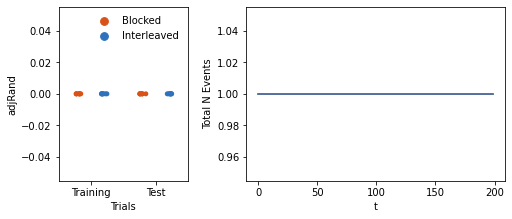

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8/2.5), sharey=False, sharex=False, 
                         gridspec_kw=dict(width_ratios=[1, 2.0], wspace=0.3))

plt.sca(axes[0])
cc = ['#D95319', '#2E72BD']

# shared_kwargs = dict(x='Adjusted Rand', y='correct (%)', ax=axes[0])
# sns.regplot(data=df[df.Condition=='Interleaved'], label='Interleaved',
#             color=cc[0], **shared_kwargs)
# sns.regplot(data=df[df.Condition=='Blocked'], label='Blocked',
#             color=cc[1], **shared_kwargs)
sns.stripplot(
    data=results[(results.Trials == 'Training') | (results.Trials == 'Test')],
    hue='Condition', x='Trials', y='adjRand',
    order=['Training', 'Test'],
              palette=cc,dodge=True,
           ax=axes[0])

plt.legend(frameon=False)

shared_kwargs = dict(x='t', y='Total N Events', ax=axes[1])
sns.lineplot(data=boundaries[boundaries.Condition == 'Interleaved'], 
            color=cc[0], **shared_kwargs)
sns.lineplot(data=boundaries[boundaries.Condition == 'Blocked'], 
            color=cc[1], **shared_kwargs)



Below: the cumulative total number of events inferred by the model over time.

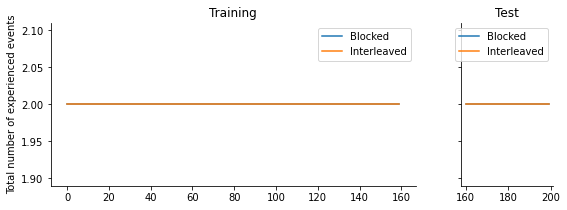

In [ ]:
ne_grouped = boundaries.groupby(['Trials', 'Condition', 't'])
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True, sharex=False,
                         gridspec_kw=dict(width_ratios=(4,1)))

def plot_with_band(trials, condition, ax):
    t = ne_grouped.mean().loc[trials].loc[condition].index
    y = ne_grouped.mean().loc[trials].loc[condition, 'Total N Events'] + 1 
    y_err = ne_grouped.std().loc[trials].loc[condition,'Total N Events'] / np.sqrt(n_batch)
    ax.plot(t, y, label=condition)
    ax.fill_between(t, y - y_err, y+y_err, alpha=0.25)
    
for ax, trials in zip(axes, ['Training', 'Test']):
    plot_with_band(trials, 'Blocked', ax)
    plot_with_band(trials, 'Interleaved', ax)
    ax.set_title(trials)
    ax.legend()
axes[0].set_ylabel('Total number of experienced events')
sns.despine()

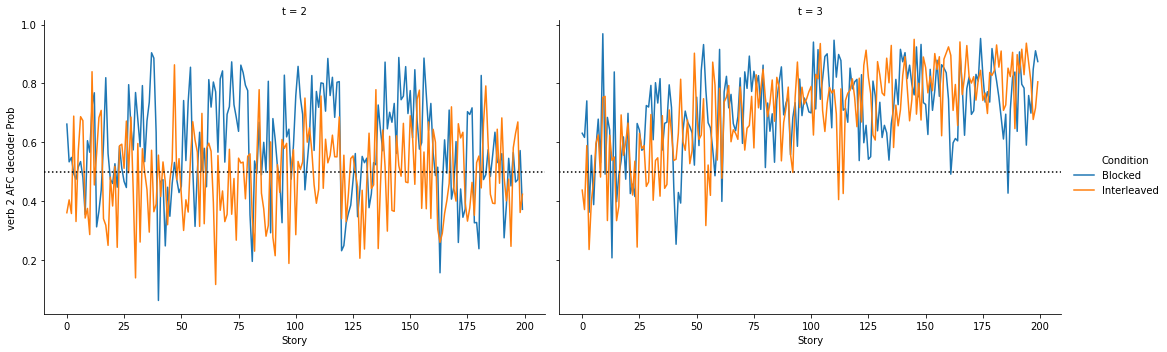

In [ ]:
measure = 'verb 2 AFC decoder Prob' # chance = 0.5
# measure = 'verb decoder Accuracy Prob'  # softmax probability

# time points 2 and 3 (following time 0: schema predictive node and, time 1:
# random node)
sel =   ((prediction_err.t == 2) | (prediction_err.t == 3)) 

g = sns.relplot(data=prediction_err[sel], x='Story', y=measure, kind='line',
                aspect=1.5, ci=None, col='t', hue='Condition'
                )
for ax in g.axes[0]:
    ax.axhline(y=0.5, ls=':', c='k')
    

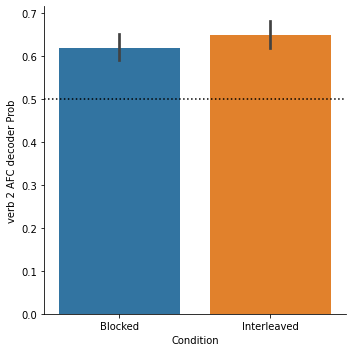

In [ ]:

sel =  ((prediction_err.t == 2) | (prediction_err.t == 3)) & \
        (prediction_err.Story > 160)

g = sns.catplot(data=prediction_err[sel], 
                y=measure, kind='bar', x='Condition',)
for ax in g.axes[0]:
    ax.axhline(y=0.5, ls=':', c='k')

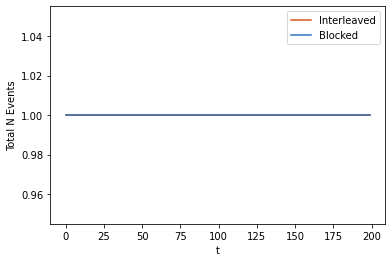

In [ ]:
shared_kwargs = dict(x='t', y='Total N Events',)
sns.lineplot(data=boundaries[(boundaries.Condition == 'Interleaved')], 
            color=cc[0], label='Interleaved', **shared_kwargs)
sns.lineplot(data=boundaries[(boundaries.Condition == 'Blocked')], 
            color=cc[1], label='Blocked', **shared_kwargs)
plt.legend()

